<div class="output_png output_subarea output_execute_result">
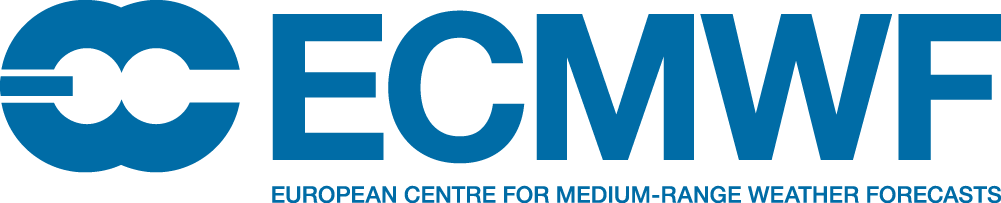
</div>

# 	Rain and mean sea level pressure

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-mslp-rain  


<div class="output_png output_subarea output_execute_result">
<center>
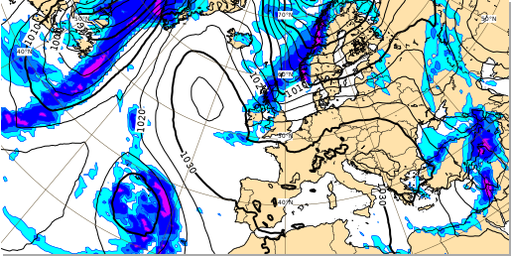</center>
</div>

The full list of available Open data products can be found [here](https://www.ecmwf.int/en/forecasts/datasets/open-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts).  

Access to ECMWF Open data is governed by the Creative Commons CC-BY-4.0 licence and associated [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).  

<sub> In applying this licence, ECMWF does not waive the privileges and immunities granted to it by virtue of its status as an intergovernmental organisation nor does it submit to any jurisdiction </sub>

To find out how to obtain the access to the full forecast dataset at higher resolution please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 2 parameters :

* [Mean sea level pressure](https://apps.ecmwf.int/codes/grib/param-db/?id=151)
* [Total precipitation](https://apps.ecmwf.int/codes/grib/param-db/?id=228228)


In this example, we will use: 
- [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client to download the data
- [**ecmwf.data**](https://github.com/ecmwf/ecmwf-data) library to read and process the data 
- [**magpye**](https://magpye.readthedocs.io) to plot the result

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-data ecmwf-opendata magpye

In [22]:
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client
import Magics.macro as magics

In [2]:
client = Client("ecmwf", beta=True)

In [3]:
parameters = ['msl', 'tp']
filename = 'medium-mslp-rain.grib'
filename

'medium-mslp-rain.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

In [4]:
client.retrieve(
    date=0,
    time=0,
    step=[12,24],
    stream="oper",
    type="fc",
    levtype="sfc",
    param=parameters,
    target=filename
)

## Reading and processing the data
Now we can use **ecmwf.data** to read the file.

In [5]:
data = ecdata.read(filename)

The **describe()** function will give us the overview of the dataset.  

In [6]:
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
msl,meanSea,0,20221217,0,"12,24",None,151,od,oper,fc,0001
tp,surface,0,20221217,0,"12,24",None,228,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [7]:
data.describe('tp')

shortName,tp
name,Total precipitation
paramId,228
units,m
typeOfLevel,surface
level,0
date,20221217
time,0
step,"12,24"
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.

In [8]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,msl,meanSea,0,20221217,0,12,fc,None,regular_ll
1,ecmf,tp,surface,0,20221217,0,0-12,fc,None,regular_ll
2,ecmf,tp,surface,0,20221217,0,0-24,fc,None,regular_ll
3,ecmf,msl,meanSea,0,20221217,0,24,fc,None,regular_ll


We can see that we have both parameters at steps 12 and 24.  

If we want to plot the total precipitation between steps 12 24 UTC, we need the data on both timesteps because total precipitation is parameter that is accumulated from the start of the forecast period. This means that step 12 has all accumulated precipitation from start of the forecast (00UTC) until 12 UTC, step 24 has accumulation from 00 to 24 UTC and so on.  
If we want the precipitation from 12 to 24 we need to deaccumulate it, by simply substracting.  
We will use the **select()** function to filter the total precipitation at different steps.

In [9]:
tp_12 = data.select(shortName='tp', step= 12)
tp_24 = data.select(shortName='tp', step= 24)
tp = (tp_24 - tp_12)
tp.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,tp,surface,0,20221217,0,0-24,fc,None,regular_ll


In [10]:
msl = data.select(shortName= 'msl', step = 24)
msl.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
msl,meanSea,0,20221217,0,24,None,151,od,oper,fc,0001


Mean sea level pressure data has unites Pa, but we want to plot it in hPa, therefore we need to convert it.

In [11]:
msl /= 100

We also need to convert total precipitation from metres to milimetres by multiplying with 1000.

In [12]:
tp = tp * 1000

## Plotting the data
And finally, we can plot the data on the map. 

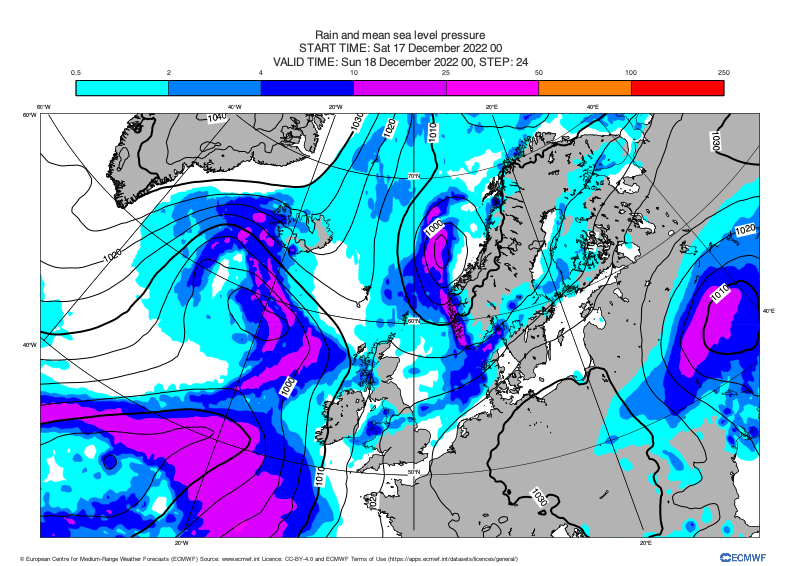

In [26]:
fig = GeoMap(area_name='north_west_europe')

fig.coastlines(land_colour="grey",resolution="high")

fig.contour_shaded(tp, style="precipitation_blue_red_250")
fig.contour_lines(msl, style="black_i5")

fig.coastlines(resolution="high")
fig.gridlines()

fig.title(["Rain and mean sea level pressure", 
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=msl' />",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=msl' />, STEP: <grib_info key='step' where='shortName=msl' />"])
fig.legend()
fig.footer("© European Centre for Medium-Range Weather Forecasts (ECMWF) Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use (https://apps.ecmwf.int/datasets/licences/general/)", logo='ecmwf')

fig.show()

Note that plot produced using open data dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
Open data is on 0.4x0.4 resolution, while high resolution data is 0.1x0.1 grid.